In [1]:
!pip --quiet install transformers

     |████████████████████████████████| 481kB 9.5MB/s 
     |████████████████████████████████| 3.1MB 62.2MB/s 
     |████████████████████████████████| 1.0MB 69.1MB/s 
     |████████████████████████████████| 870kB 73.4MB/s 


In [1]:
import sys
if 'google.colab' in sys.modules: # Colab-only Tensorflow version selector
  %tensorflow_version 2.x

import tensorflow as tf
print("Tensorflow version " + tf.__version__)

TensorFlow 2.x selected.
Tensorflow version 2.1.0


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!cp -r '/content/drive/My Drive/Colab Notebooks/Google QUEST Q&A Labeling/Scripts/.' .

In [0]:
MODEL_BASE_PATH = '/content/drive/My Drive/Colab Notebooks/Google QUEST Q&A Labeling/Model backlog/Files/'
MODEL_NAME = '155-DistilBert'

## Dependencies

In [5]:
import glob
import html
import warnings
from tensorflow.keras import Model, optimizers
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling1D, Concatenate
from googleqa_utilityscript import *
from script_lr_schedulers import WarmUpLearningRateScheduler
from transformers import DistilBertConfig, DistilBertTokenizer, TFDistilBertModel


SEED = 0
seed_everything(SEED)
warnings.filterwarnings("ignore")

Using TensorFlow backend.


## Load data

In [6]:
MODULE_BASE_PATH = '/content/drive/My Drive/Colab Notebooks/Google QUEST Q&A Labeling/Modules/distilbert/distilbert-base-uncased'
MODULE_PATH = MODULE_BASE_PATH + '/distilbert-base-uncased-tf_model.h5'
VOCAB_PATH = MODULE_BASE_PATH + '/bert-base-uncased-vocab.txt'
CONF_PATH = MODULE_BASE_PATH + '/distilbert-base-uncased-config.json'

k_fold = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Google QUEST Q&A Labeling/Data/5-fold.csv')
N_FOLDS = 5

print('Samples: %s' % len(k_fold))
display(k_fold.head())

Samples: 6079


,qa_id,question_title,question_body,question_user_name,question_user_page,answer,answer_user_name,answer_user_page,url,category,host,question_asker_intent_understanding,question_body_critical,question_conversational,question_expect_short_answer,question_fact_seeking,question_has_commonly_accepted_answer,question_interestingness_others,question_interestingness_self,question_multi_intent,question_not_really_a_question,question_opinion_seeking,question_type_choice,question_type_compare,question_type_consequence,question_type_definition,question_type_entity,question_type_instructions,question_type_procedure,question_type_reason_explanation,question_type_spelling,question_well_written,answer_helpful,answer_level_of_information,answer_plausible,answer_relevance,answer_satisfaction,answer_type_instructions,answer_type_procedure,answer_type_reason_explanation,answer_well_written,fold_1,fold_2,fold_3,fold_4,fold_5
0,0,What am I losing when using extension tubes in...,After playing around with macro photography on...,ysap,https://photo.stackexchange.com/users/1024,"I just got extension tubes, so here's the skin...",rfusca,https://photo.stackexchange.com/users/1917,http://photo.stackexchange.com/questions/9169/...,LIFE_ARTS,photo.stackexchange.com,1.000000,0.333333,0.000000,0.0,0.0,0.0,1.000000,1.000000,0.000000,0.0,1.000000,0.000000,0.000000,0.0,0.000000,0.0,1.0,0.000000,0.000000,0.0,1.000000,1.000000,0.666667,1.000000,1.000000,0.800000,1.0,0.000000,0.000000,1.000000,train,train,train,validation,train
1,1,What is the distinction between a city and a s...,I am trying to understand what kinds of places...,russellpierce,https://rpg.stackexchange.com/users/8774,It might be helpful to look into the definitio...,Erik Schmidt,https://rpg.stackexchange.com/users/1871,http://rpg.stackexchange.com/questions/47820/w...,CULTURE,rpg.stackexchange.com,1.000000,1.000000,0.000000,0.5,1.0,1.0,0.444444,0.444444,0.666667,0.0,0.000000,0.666667,0.666667,0.0,0.333333,0.0,0.0,0.000000,0.333333,0.0,0.888889,0.888889,0.555556,0.888889,0.888889,0.666667,0.0,0.000000,0.666667,0.888889,validation,train,train,train,train
2,2,Maximum protusion length for through-hole comp...,I'm working on a PCB that has through-hole com...,Joe Baker,https://electronics.stackexchange.com/users/10157,Do you even need grooves? We make several pro...,Dwayne Reid,https://electronics.stackexchange.com/users/64754,http://electronics.stackexchange.com/questions...,SCIENCE,electronics.stackexchange.com,0.888889,0.666667,0.000000,1.0,1.0,1.0,0.666667,0.444444,0.333333,0.0,0.333333,0.000000,0.000000,0.0,0.000000,0.0,1.0,0.333333,0.333333,0.0,0.777778,0.777778,0.555556,1.000000,1.000000,0.666667,0.0,0.333333,1.000000,0.888889,train,train,validation,train,train
3,3,Can an affidavit be used in Beit Din?,"An affidavit, from what i understand, is basic...",Scimonster,https://judaism.stackexchange.com/users/5151,"Sending an ""affidavit"" it is a dispute between...",Y e z,https://judaism.stackexchange.com/users/4794,http://judaism.stackexchange.com/questions/551...,CULTURE,judaism.stackexchange.com,0.888889,0.666667,0.666667,1.0,1.0,1.0,0.444444,0.444444,0.000000,0.0,0.000000,1.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.888889,0.833333,0.333333,0.833333,1.000000,0.800000,0.0,0.000000,1.000000,1.000000,train,train,train,train,validation
4,5,How do you make a binary image in Photoshop?,I am trying to make a binary image. I want mor...,leigero,https://graphicdesign.stackexchange.com/users/...,Check out Image Trace in Adobe Illustrator. \n...,q2ra,https://graphicdesign.stackexchange.com/users/...,http://graphicdesign.stackexchange.com/questio...,LIFE_ARTS,graphicdesign.stackexchange.com,1.000000,0.666667,0.000000,1.0,1.0,1.0,0.666667,0.666667,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,1.0,0.000000,1.000000,0.0,1.000000,1.000000,0.666667,1.000000,1.000000,0.800000,1.0,0.000000,1.000000,1.000000,validation,train,train,train,train


In [0]:
question_target_cols = ['question_asker_intent_understanding','question_body_critical', 'question_conversational', 
                        'question_expect_short_answer', 'question_fact_seeking', 'question_has_commonly_accepted_answer',
                        'question_interestingness_others', 'question_interestingness_self', 'question_multi_intent', 
                        'question_not_really_a_question', 'question_opinion_seeking', 'question_type_choice',
                        'question_type_compare', 'question_type_consequence', 'question_type_definition', 
                        'question_type_entity', 'question_type_instructions', 'question_type_procedure',
                        'question_type_reason_explanation', 'question_type_spelling', 'question_well_written']
answer_target_cols = ['answer_helpful', 'answer_level_of_information', 'answer_plausible', 'answer_relevance',
                      'answer_satisfaction', 'answer_type_instructions', 'answer_type_procedure', 
                      'answer_type_reason_explanation', 'answer_well_written']
target_cols = question_target_cols + answer_target_cols

In [0]:
### BERT auxiliar function
def _get_masks(tokens, max_seq_length):
    """Mask for padding"""
    if len(tokens)>max_seq_length:
        raise IndexError("Token length more than max seq length!")
    return [1]*len(tokens) + [0] * (max_seq_length - len(tokens))

def _get_segments(tokens, max_seq_length, ignore_first_sep=True):
    """Segments: 0 for the first sequence, 1 for the second"""
    if len(tokens)>max_seq_length:
        raise IndexError("Token length more than max seq length!")
    segments = []
    current_segment_id = 0
    for token in tokens:
        segments.append(current_segment_id)
        if token == "[SEP]":
            if ignore_first_sep:
                ignore_first_sep = False 
            else:
                current_segment_id = 1
    return segments + [0] * (max_seq_length - len(tokens))

def _get_ids(tokens, tokenizer, max_seq_length):
    """Token ids from Tokenizer vocab"""
    token_ids = tokenizer.convert_tokens_to_ids(tokens)
    input_ids = token_ids + [0] * (max_seq_length-len(token_ids))
    return input_ids

def _trim_input_2_tail(ft_input1, ft_input2, tokenizer, max_sequence_length, 
                  max_len_ft1=254, max_len_ft2=255):

    ft1 = tokenizer.tokenize(ft_input1)
    ft2 = tokenizer.tokenize(ft_input2)
    
    ft1_len = len(ft1)
    ft2_len = len(ft2)

    if (ft1_len + ft2_len + 3) > max_sequence_length:
      
        if max_len_ft2 > ft2_len:
            ft2_new_len = ft2_len 
            ft1_new_len = max_len_ft1 + (max_len_ft2 - ft2_len)
        elif max_len_ft1 > ft1_len:
            ft2_new_len = max_len_ft2 + (max_len_ft1 - ft1_len)
            ft1_new_len = ft1_len
        else:
            ft2_new_len = max_len_ft2
            ft1_new_len = max_len_ft1
                        
        if ft1_new_len + ft2_new_len + 3 > max_sequence_length:
            raise ValueError("New sequence length should be %d, but is %d" 
                             % (max_sequence_length, (ft1_new_len + ft2_new_len + 3)))
        
        ft1 = ft1[-ft1_new_len:]
        ft2 = ft2[-ft2_new_len:]
        
    return ft1, ft2

def _convert_to_bert_inputs_2(feature1, feature2, tokenizer, max_sequence_length, ignore_first_sep=True):
    """Converts tokenized input to ids, masks and segments for BERT"""
    
    stoken = ["[CLS]"] + feature1 + ["[SEP]"] + feature2 + ["[SEP]"]

    input_ids = _get_ids(stoken, tokenizer, max_sequence_length)
    input_masks = _get_masks(stoken, max_sequence_length)
    input_segments = _get_segments(stoken, max_sequence_length, ignore_first_sep)

    return [input_ids, input_masks, input_segments]

def compute_input_arays_2_tail(df, columns, tokenizer, max_sequence_length, 
                          max_len_ft1, max_len_ft2, ignore_first_sep=True):
    input_ids, input_masks, input_segments = [], [], []
    for _, instance in df[columns].iterrows():
        ft1, ft2 = instance[columns[0]], instance[columns[1]]

        ft1, ft2 = _trim_input_2_tail(ft1, ft2, tokenizer, max_sequence_length, 
                                      max_len_ft1, max_len_ft2)

        ids, masks, segments = _convert_to_bert_inputs_2(ft1, ft2, tokenizer, max_sequence_length, 
                                                         ignore_first_sep)
        input_ids.append(ids)
        input_masks.append(masks)
        input_segments.append(segments)
        
    return [np.asarray(input_ids, dtype=np.int32), 
            np.asarray(input_masks, dtype=np.int32), 
            np.asarray(input_segments, dtype=np.int32)]

# Pre-process data

In [0]:
text_features = ['question_title', 'question_body', 'answer']
text_features_question = ['question_title', 'question_body']
text_features_answer = ['question_title', 'answer']

k_fold['question_title'] = k_fold['question_title'].apply(html.unescape)
k_fold['question_body'] = k_fold['question_body'].apply(html.unescape)
k_fold['answer'] = k_fold['answer'].apply(html.unescape)

# Model parameters

In [0]:
EPOCHS = 8
BATCH_SIZE = 10
LEARNING_RATE = 3e-5
N_CLASS = len(target_cols)
N_CLASS_QUESTION = len(question_target_cols)
N_CLASS_ANSWER = len(answer_target_cols)
ES_PATIENCE = 1
LR_WARMUP_EPOCHS = 2
MAX_SEQUENCE_LENGTH = 512
MAX_LENGTH_TITLE = 30
MAX_LENGTH_QUESTION = 479
MAX_LENGTH_ANSWER = 479

# Model

In [0]:
module_config = DistilBertConfig.from_pretrained(CONF_PATH)
module_config.output_hidden_states=False

def model_fn():
    input_word_ids_question = Input((MAX_SEQUENCE_LENGTH,), dtype=tf.int32, name='input_word_ids_question')
    input_masks_question = Input((MAX_SEQUENCE_LENGTH,), dtype=tf.int32, name='input_masks_question')
    segment_ids_question = Input((MAX_SEQUENCE_LENGTH,), dtype=tf.int32, name='segment_ids_question')

    input_word_ids_answer = Input((MAX_SEQUENCE_LENGTH,), dtype=tf.int32, name='input_word_ids_answer')
    input_masks_answer = Input((MAX_SEQUENCE_LENGTH,), dtype=tf.int32, name='input_masks_answer')
    segment_ids_answer = Input((MAX_SEQUENCE_LENGTH,), dtype=tf.int32, name='segment_ids_answer')

    module_model = TFDistilBertModel.from_pretrained(MODULE_PATH, config=module_config)
    sequence_output_question = module_model([input_word_ids_question, input_masks_question])
    sequence_output_answer = module_model([input_word_ids_answer, input_masks_answer])

    sequence_output_question = sequence_output_question[0] # The last hidden-state is the first element of the output tuple
    sequence_output_answer = sequence_output_answer[0] # The last hidden-state is the first element of the output tuple
    
    x_question = GlobalAveragePooling1D()(sequence_output_question)
    x_question = Dropout(0.2)(x_question)
    output_question = Dense(N_CLASS_QUESTION, kernel_initializer='glorot_uniform', activation="sigmoid", name="output_question")(x_question)
    
    x_answer = GlobalAveragePooling1D()(sequence_output_answer)
    x_answer = Dropout(0.2)(x_answer)
    output_answer = Dense(N_CLASS_ANSWER, kernel_initializer='glorot_uniform', activation="sigmoid", name="output_answer")(x_answer)
    
    output = Concatenate()([output_question, output_answer])

    model = Model(inputs=[input_word_ids_question, input_masks_question, segment_ids_question, 
                          input_word_ids_answer, input_masks_answer, segment_ids_answer], outputs=output)

    return model

# Train model

In [14]:
tokenizer = DistilBertTokenizer.from_pretrained(VOCAB_PATH, do_lower_case=True)

history_list = []
metric_list = []
category_metric_list = []
target_cols_preds = [col+'_pred' for col in target_cols]

for n_fold in range(N_FOLDS):
    ### Data
    train = k_fold[k_fold['fold_%d' % (n_fold+1)] == 'train']
    validation = k_fold[k_fold['fold_%d' % (n_fold+1)] == 'validation']
    
    ### Create features
    # Train features
    X_train_head = compute_input_arays_2(train, text_features_question, tokenizer, MAX_SEQUENCE_LENGTH, 
                                          MAX_LENGTH_TITLE, MAX_LENGTH_QUESTION, ignore_first_sep=False)\
                    + compute_input_arays_2(train, text_features_answer, tokenizer, MAX_SEQUENCE_LENGTH, 
                                             MAX_LENGTH_TITLE, MAX_LENGTH_ANSWER, ignore_first_sep=False)
                    
    X_train_tail = compute_input_arays_2_tail(train, text_features_question, tokenizer, MAX_SEQUENCE_LENGTH, 
                                              MAX_LENGTH_TITLE, MAX_LENGTH_QUESTION, ignore_first_sep=False)\
                    + compute_input_arays_2_tail(train, text_features_answer, tokenizer, MAX_SEQUENCE_LENGTH, 
                                                  MAX_LENGTH_TITLE, MAX_LENGTH_ANSWER, ignore_first_sep=False)
                
    Y_train = train[target_cols].values

    X_train = list(np.hstack((np.asarray(X_train_head), np.asarray(X_train_tail))))
    Y_train = np.vstack((Y_train, Y_train))

    # Validation features
    X_valid = compute_input_arays_2(validation, text_features_question, tokenizer, MAX_SEQUENCE_LENGTH, 
                                    MAX_LENGTH_TITLE, MAX_LENGTH_QUESTION, ignore_first_sep=False)\
              + compute_input_arays_2(validation, text_features_answer, tokenizer, MAX_SEQUENCE_LENGTH, 
                                      MAX_LENGTH_TITLE, MAX_LENGTH_ANSWER, ignore_first_sep=False)
                    
    Y_valid = validation[target_cols].values
    
    # Train model
    model_path = MODEL_BASE_PATH + MODEL_NAME + '_model_fold_%d' % (n_fold+1)
    spearmanCallback = SpearmanRhoCallback(training_data=(X_train, Y_train), 
                                           validation_data=(X_valid, Y_valid), 
                                           model_path=model_path, 
                                           monitor='val_loss', mode='min', 
                                           patience=ES_PATIENCE, checkpoint=True)
    WARMUP_BATCHES = LR_WARMUP_EPOCHS * len(train) // BATCH_SIZE
    warmup_lr = WarmUpLearningRateScheduler(WARMUP_BATCHES, LEARNING_RATE)

    callback_list = [spearmanCallback, warmup_lr]
    optimizer = optimizers.Adam(lr=LEARNING_RATE)
    model = model_fn()
    model.compile(optimizer=optimizer, loss='binary_crossentropy')

    history = model.fit(X_train, Y_train, 
                        validation_data=(X_valid, Y_valid), 
                        callbacks=callback_list, 
                        batch_size=BATCH_SIZE, 
                        epochs=EPOCHS, 
                        verbose=2).history
    history_list.append(history)

    # Save last epoch weights
    model.save_weights(MODEL_BASE_PATH + MODEL_NAME + '_model_fold_%d_last_epoch.h5' % (n_fold+1))
    
    ### Evaluation - Label metrics
    model.load_weights(model_path+'.h5')
    preds_train = model.predict(X_train_head)
    preds_val = model.predict(X_valid)
    metric_list.append(get_metrics(train[target_cols].values, preds_train, Y_valid, preds_val, target_cols))
    
    ### Evaluation - Category metrics
    for col in target_cols_preds:
        train[col] = 0
        validation[col] = 0

    train[target_cols_preds] = preds_train
    validation[target_cols_preds] = preds_val
    category_metric_list.append(get_metrics_category(train, validation, target_cols, target_cols_preds, 'category'))

Calling DistilBertTokenizer.from_pretrained() with the path to a single file or url is deprecated


Train on 9728 samples, validate on 1215 samples
Epoch 1/8
spearman-rho: 0.4210 val_spearman-rho: 0.3804
Saved model weights at "/content/drive/My Drive/Colab Notebooks/Google QUEST Q&A Labeling/Model backlog/Files/155-DistilBert_model_fold_1.h5"
9728/9728 - 920s - loss: 0.4256 - val_loss: 0.3743
Epoch 2/8
spearman-rho: 0.5093 val_spearman-rho: 0.3920
Saved model weights at "/content/drive/My Drive/Colab Notebooks/Google QUEST Q&A Labeling/Model backlog/Files/155-DistilBert_model_fold_1.h5"
9728/9728 - 903s - loss: 0.3609 - val_loss: 0.3678
Epoch 3/8
spearman-rho: 0.5784 val_spearman-rho: 0.3854
Epoch 00002: early stopping
9728/9728 - 902s - loss: 0.3383 - val_loss: 0.3802
Train on 9728 samples, validate on 1215 samples
Epoch 1/8
spearman-rho: 0.4166 val_spearman-rho: 0.3687
Saved model weights at "/content/drive/My Drive/Colab Notebooks/Google QUEST Q&A Labeling/Model backlog/Files/155-DistilBert_model_fold_2.h5"
9728/9728 - 919s - loss: 0.4266 - val_loss: 0.3736
Epoch 2/8
spearman-rho

## Model loss graph

Fold: 0


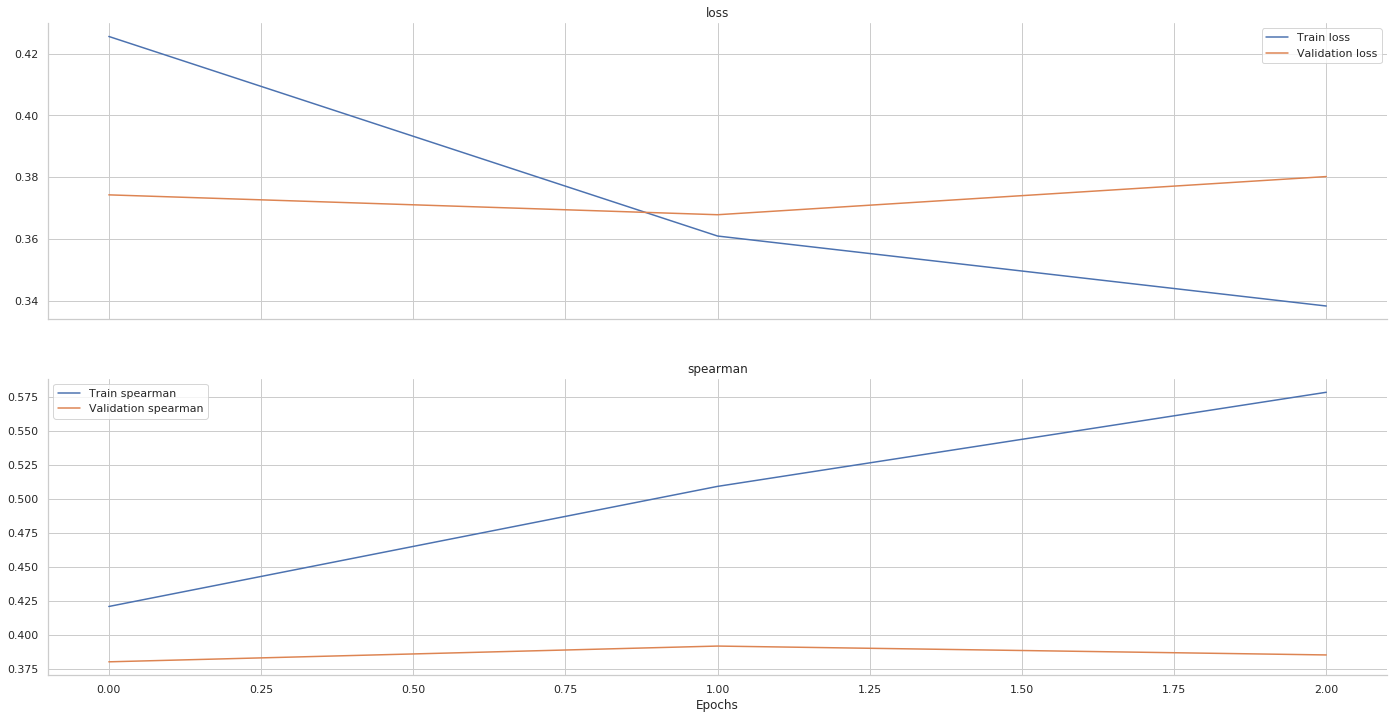

Fold: 1


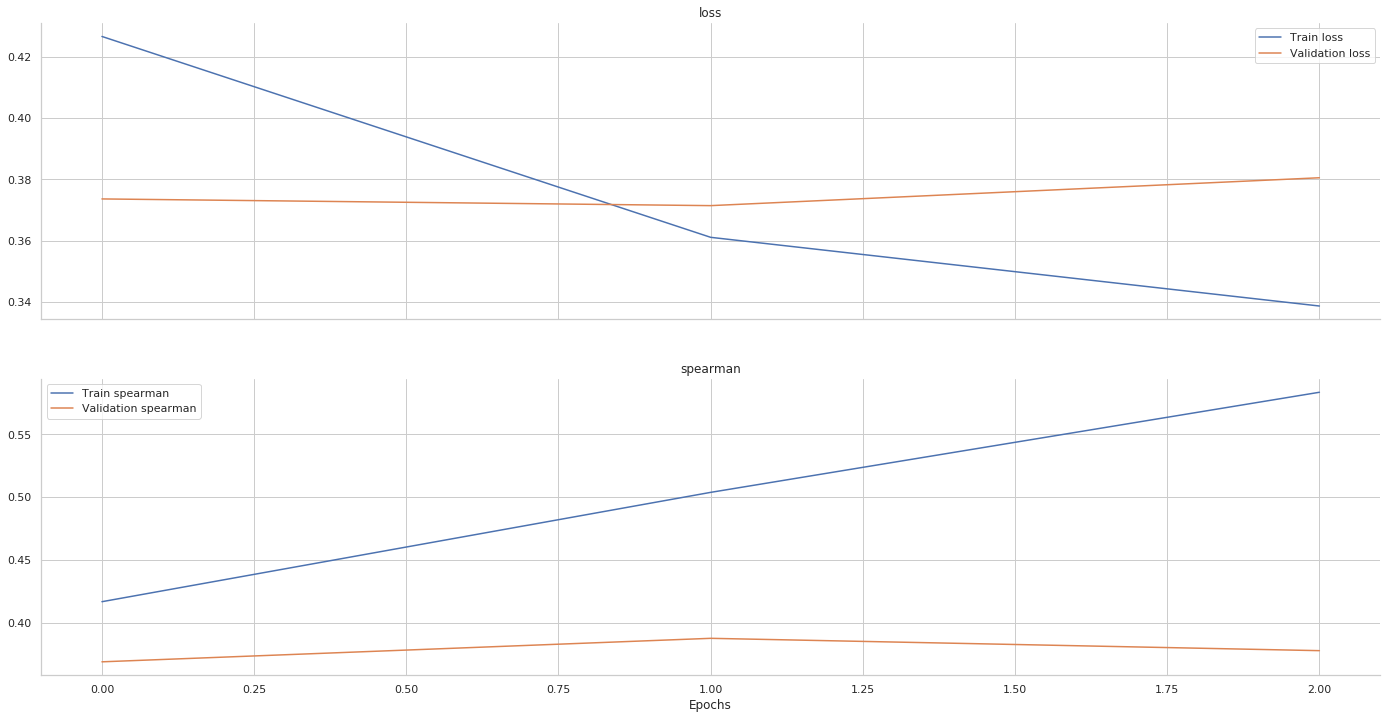

Fold: 2


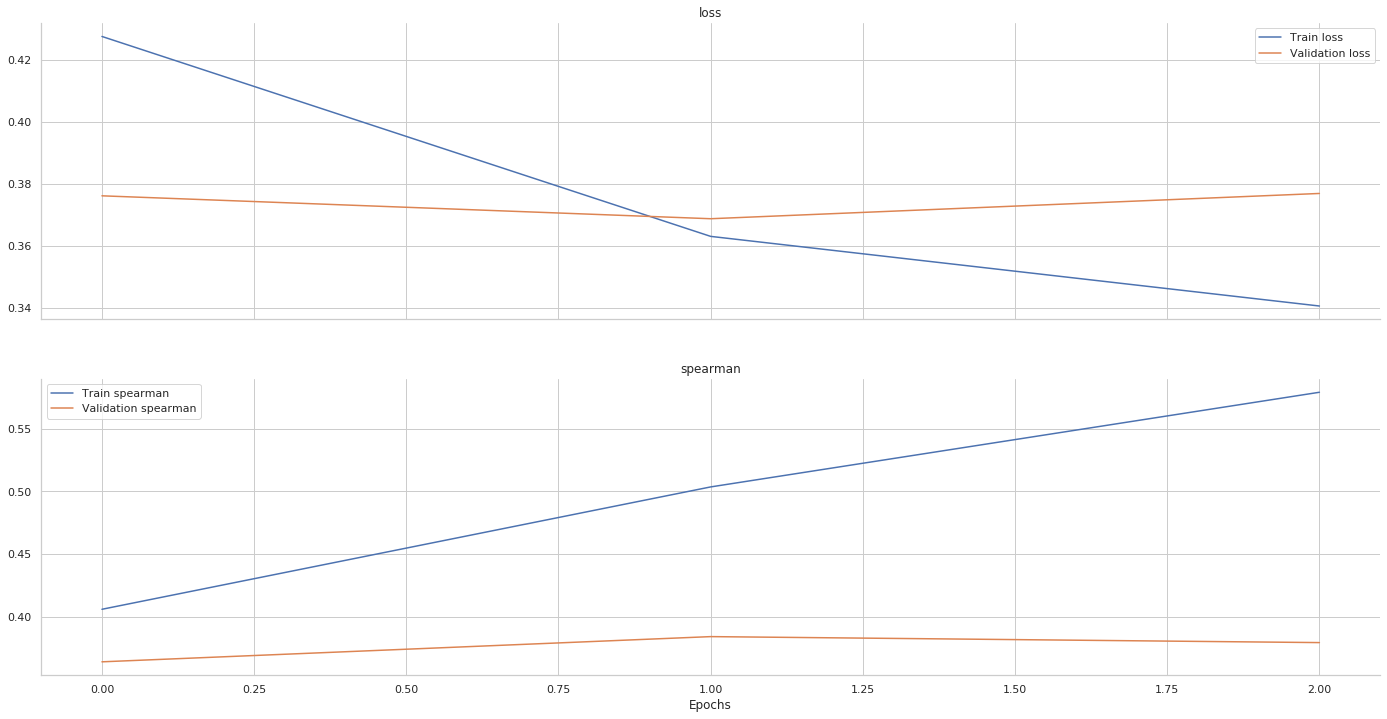

Fold: 3


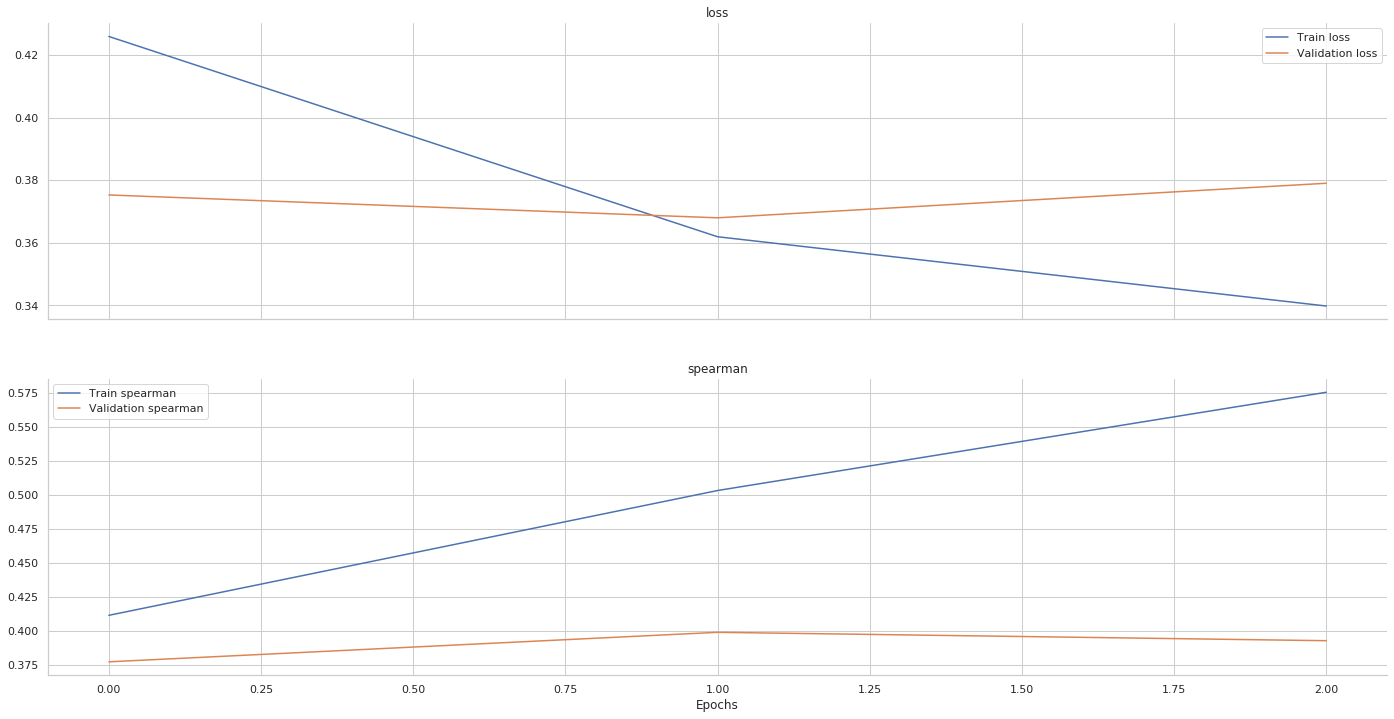

Fold: 4


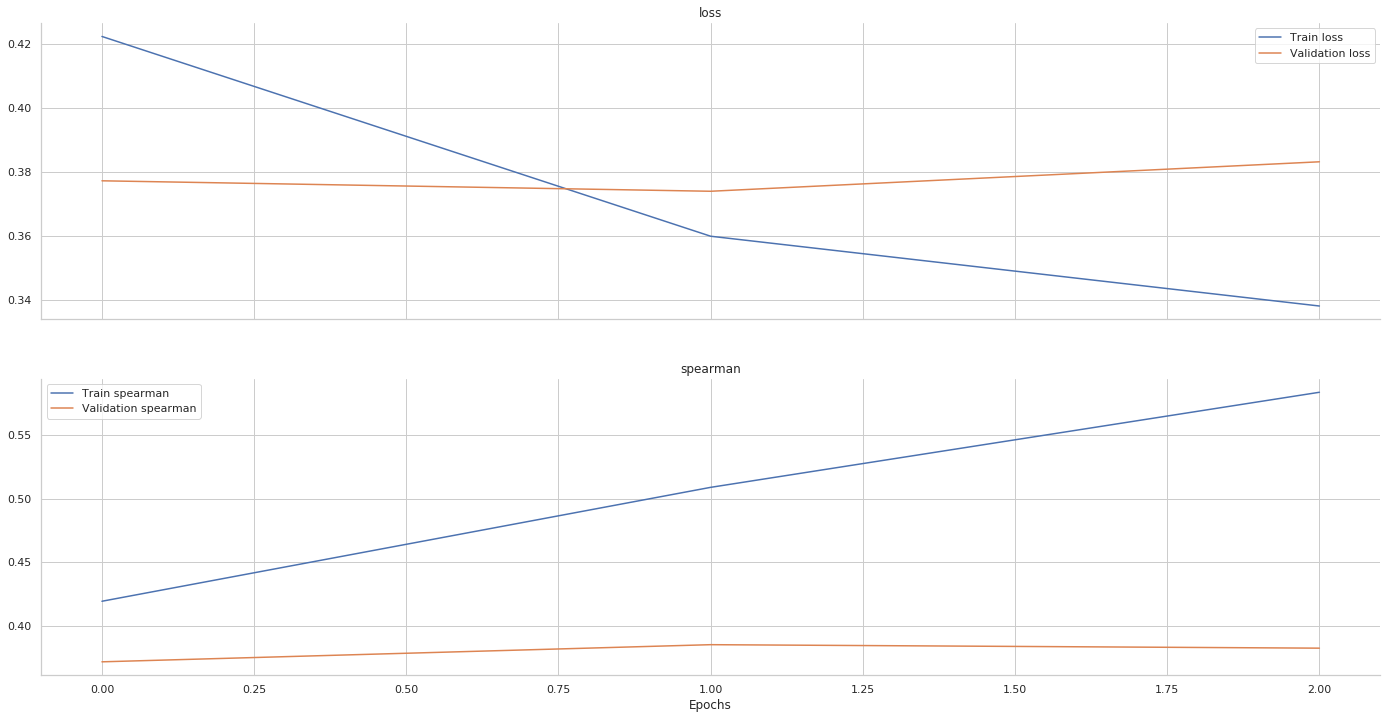

In [15]:
for n_fold in range(N_FOLDS):
    print('Fold: %d' % n_fold)
    sns.set(style="whitegrid")
    plot_metrics(history_list[n_fold], metric_list=['loss', 'spearman'])

# Evaluation

In [16]:
metrics_df = metric_list[0][['Label', 'Train', 'Validation']].copy()
metrics_df.columns = ['Label', 'Train_fold_0', 'Valid_fold_0']

for n_fold in range(1, N_FOLDS):
    metrics_df_idx = metric_list[n_fold][['Train', 'Validation']].copy()
    metrics_df_idx.columns = ['Train_fold_%d' % n_fold, 'Valid_fold_%d' % n_fold]
    metrics_df = pd.concat([metrics_df, metrics_df_idx], axis=1)

metrics_df['Train'] = 0
metrics_df['Validation'] = 0
for n_fold in range(N_FOLDS):
    metrics_df['Train'] += metrics_df['Train_fold_%d' % n_fold] / N_FOLDS
    metrics_df['Validation'] += metrics_df['Valid_fold_%d' % n_fold] / N_FOLDS

metrics_df['Var'] = metrics_df['Train'] - metrics_df['Validation']
display(metrics_df.style.applymap(color_map))

,Label,Train_fold_0,Valid_fold_0,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3,Train_fold_4,Valid_fold_4,Train,Validation,Var
0,Averaged,0.509,0.392,0.503,0.387,0.504,0.384,0.503,0.399,0.509,0.385,0.5056,0.3894,0.1162
1,Question averaged,0.522,0.418,0.515,0.418,0.517,0.418,0.514,0.428,0.518,0.411,0.5172,0.4186,0.0986
2,Answer averaged,0.479,0.332,0.475,0.316,0.471,0.306,0.477,0.331,0.487,0.326,0.4778,0.3222,0.1556
3,question_asker_intent_understanding,0.457,0.336,0.427,0.38,0.478,0.33,0.452,0.359,0.464,0.35,0.4556,0.351,0.1046
4,question_body_critical,0.726,0.603,0.697,0.654,0.724,0.631,0.706,0.644,0.702,0.61,0.711,0.6284,0.0826
5,question_conversational,0.465,0.423,0.468,0.399,0.464,0.427,0.469,0.422,0.467,0.401,0.4666,0.4144,0.0522
6,question_expect_short_answer,0.514,0.32,0.495,0.243,0.485,0.245,0.492,0.288,0.503,0.289,0.4978,0.277,0.2208
7,question_fact_seeking,0.535,0.376,0.563,0.336,0.559,0.383,0.558,0.355,0.568,0.309,0.5566,0.3518,0.2048
8,question_has_commonly_accepted_answer,0.586,0.436,0.584,0.419,0.578,0.396,0.567,0.431,0.576,0.423,0.5782,0.421,0.1572
9,question_interestingness_others,0.436,0.299,0.433,0.318,0.443,0.314,0.422,0.307,0.417,0.32,0.4302,0.3116,0.1186


## By category

In [17]:
category_metrics_df = category_metric_list[0][['Label', 'Train', 'Validation']].copy()
category_metrics_df.columns = ['Label', 'Train_fold_0', 'Valid_fold_0']

for n_fold in range(1, N_FOLDS):
    category_metrics_df_idx = category_metric_list[n_fold][['Train', 'Validation']].copy()
    category_metrics_df_idx.columns = ['Train_fold_%d' % n_fold, 'Valid_fold_%d' % n_fold]
    category_metrics_df = pd.concat([category_metrics_df, category_metrics_df_idx], axis=1)
    
category_metrics_df['Train'] = 0
category_metrics_df['Validation'] = 0
for n_fold in range(N_FOLDS):
    category_metrics_df['Train'] += category_metrics_df['Train_fold_%d' % n_fold] / N_FOLDS
    category_metrics_df['Validation'] += category_metrics_df['Valid_fold_%d' % n_fold] / N_FOLDS
    
category_metrics_df['Var'] = category_metrics_df['Train'] - category_metrics_df['Validation']
display(category_metrics_df.style.applymap(color_map))

,Label,Train_fold_0,Valid_fold_0,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3,Train_fold_4,Valid_fold_4,Train,Validation,Var
0,LIFE_ARTS,0.537,0.413,0.541,0.404,0.539,0.412,0.533,0.395,0.538,0.397,0.5376,0.4042,0.1334
1,SCIENCE,0.533,0.41,0.54,0.363,0.527,0.389,0.525,0.39,0.534,0.373,0.5318,0.385,0.1468
2,CULTURE,0.542,0.412,0.521,0.387,0.473,0.341,0.549,0.423,0.528,0.411,0.5226,0.3948,0.1278
3,STACKOVERFLOW,0.406,0.261,0.394,0.279,0.529,0.388,0.395,0.271,0.399,0.259,0.4246,0.2916,0.133
4,TECHNOLOGY,0.478,0.35,0.471,0.354,0.394,0.253,0.472,0.365,0.479,0.345,0.4588,0.3334,0.1254
